In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display

sns.set_theme()

### Data import

In [3]:
df = pd.read_pickle("../data/data_prepared.pkl")
start_date = df.index.min()
end_date =df.index.max()
print(start_date, end_date)
weather = pd.DataFrame()
w_parameters = ["wind_speed", "sunshine_duration", "pressure_air_site", "temperature_air_mean_200", "cloud_cover_total"]
for par in w_parameters[0:1]:
    df_w = pd.read_pickle("../data/weather/cleaned/"+par+".pkl")
    weather = pd.concat([weather, df_w], axis=1)
weather = weather[start_date:end_date]
print(weather.shape)
print(df.shape)

2020-01-01 00:00:00+00:00 2021-12-31 23:00:00+00:00
(17544, 12)
(17544, 8)


In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

num_features = df.shape[1]

In [5]:
print(column_indices)
print(df.shape)

{'prod_wind': 0, 'prod_solar': 1, 'day_sin': 2, 'day_cos': 3, 'year_sin': 4, 'year_cos': 5, 'solar_el': 6, 'solar_el_clip': 7}
(17544, 8)


In [6]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# scaler_el = MinMaxScaler()
# scaler_meta = MinMaxScaler()
# scaler_weather = MinMaxScaler()
scaler_el = RobustScaler()
scaler_meta = RobustScaler()
scaler_weather = RobustScaler()
df_el = df.loc[:, ["prod_wind", "prod_solar"]]
df_meta = df.drop(["prod_wind", "prod_solar", "solar_el"], axis=1)
# fit scaler to training data
_ = scaler_el.fit(df_el)
_ = scaler_meta.fit(df_meta)
_ = scaler_weather.fit(weather)
# scale all sets according to train set, preserve data frames
# df_train = pd.DataFrame(scaler.transform(df_train),
#                         columns=df.columns, index=df_train.index)
# df_val = pd.DataFrame(scaler.transform(df_val),
#                         columns=df.columns, index=df_val.index)
# df_test = pd.DataFrame(scaler.transform(df_test),
#                         columns=df.columns, index=df_test.index)

In [9]:
time = df_el.index
scaled_el = pd.DataFrame(data=scaler_el.transform(df_el), columns=df_el.columns, index=time)
scaled_meta = pd.DataFrame(data=scaler_meta.transform(df_meta), columns=df_meta.columns, index=time)
scaled_weather = pd.DataFrame(data=scaler_weather.transform(weather), columns=weather.columns, index=time)
# scaled[:7*24].plot(subplots=True)
# y=scaled.to_numpy()
y_df=scaled_el
print(y_df.shape)

# x = pd.concat([df_meta, weather], axis=1).to_numpy()
x_df = pd.concat([scaled_meta, scaled_weather], axis=1)
print(x_df.shape)
# scaled_meta[:7*24].plot(subplots=True)

(17544, 2)
(17544, 17)


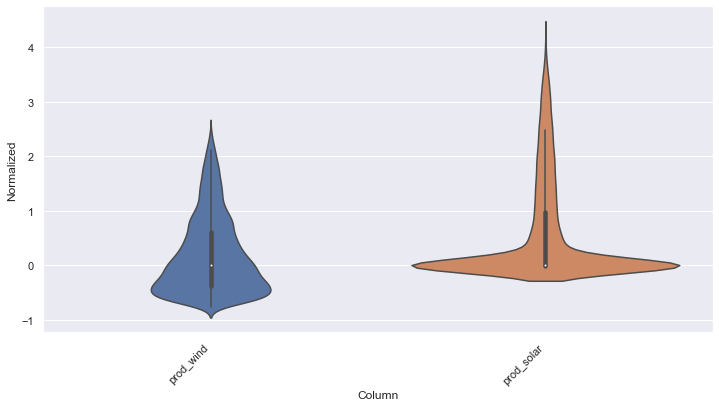

In [10]:
df_plot = y_df.melt(var_name='Column', value_name='Normalized')
df_plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_plot)
_ = ax.set_xticklabels(y_df.keys(), rotation=45, ha='right')

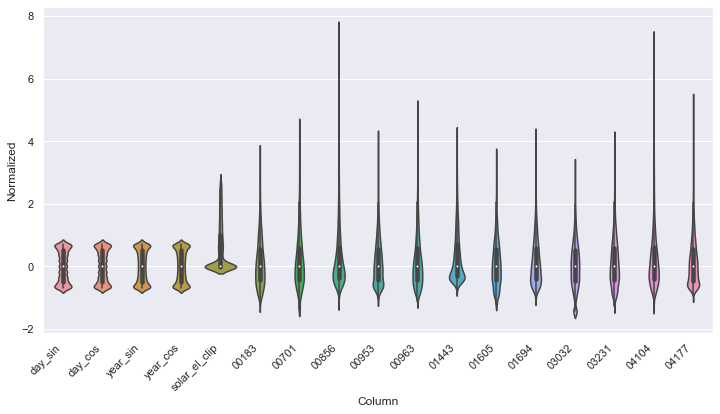

In [11]:
df_plot = x_df.melt(var_name='Column', value_name='Normalized')
df_plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_plot)
_ = ax.set_xticklabels(x_df.keys(), rotation=45, ha='right')

### Model Setup

In [12]:
def multivariate_data(dataset, target, time_vector, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    time_windows = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        time_windows.append(time_vector[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels), time_windows

In [13]:
x=x_df.to_numpy()
y=y_df.to_numpy()
print(x.shape, y.shape)

(17544, 17) (17544, 2)


In [14]:
# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])
print(testsplit)
# how many "x" inputs to provide/how many timesteps to use in the RNN
past_history = 24*7

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 24

# this can be set to 1. If you have extremely large datasets where values 
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used 
step = 1

# prepare the data
# inputs here are y and y, since now we're predicting all features, using all features 
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_multi, y_train_multi, time_train = multivariate_data(x, y, time, 0, testsplit, 
                                                 past_history, future_target, step,
                                                 single_step=False)
x_test_multi, y_test_multi, time_test   = multivariate_data(x, y, time, testsplit, None, 
                                                 past_history, future_target, step,
                                                 single_step=False)

# print shapes
print("shape of y:", y.shape)
print("shapes of x_train and y_train: ", x_train_multi.shape, y_train_multi.shape)
print("shapes of x_test and y_test: ", x_test_multi.shape, y_test_multi.shape)

14035
shape of y: (17544, 2)
shapes of x_train and y_train:  (13867, 168, 17) (13867, 24, 2)
shapes of x_test and y_test:  (3317, 168, 17) (3317, 24, 2)


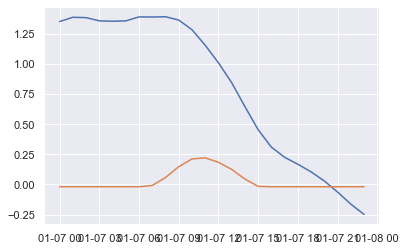

In [17]:
_ = plt.plot(time_train[0][-24:], y_train_multi[0])

In [18]:
# print a few values
print(x_train_multi[0,0,:])

print()
# you can check other components by changing the last "1" index
print("x_train[300]: ", x_train_multi[300][:3][:,1], "...")
print("y_train[0] :  ", y_train_multi[0][:3][:,1], "...")

input_shape = x_train_multi.shape[-2:]
print(input_shape)

[-5.43796191e-12  7.07106781e-01 -1.79780635e-03  7.05989873e-01
 -1.93232184e-02  1.91489362e-01 -1.00000000e+00 -4.76190476e-01
 -6.45161290e-01 -9.28571429e-01 -1.92307692e-01 -3.00000000e-01
  3.84615385e-02 -1.44680851e+00 -8.57142857e-01  6.66666667e-02
  6.00000000e-01]

x_train[300]:  [-0.70710678 -0.6830127  -0.61237244] ...
y_train[0] :   [-0.01968239 -0.01968239 -0.01968239] ...
(168, 17)


In [19]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session

clear_session()

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# create an "Input" layer with the correct shape to tell the network what to expect
inp = Input(x_train_multi.shape[-2:])

# directly assign an LSTM layer to a variable called "bm" here, similar to what
# we did in assignment 03 when creating a base model for image recognition
# it should look like "bm = ...($numberOfLSTMComponents)(inp)", the (inp) at the 
# end attaches this layer to the input layer
# use 128 components again
# YOUR CODE HERE
bm=LSTM(128)(inp)
#raise NotImplementedError()

# now we need 4 Dense layers. create 4 variables called "out1", "out2", "out3", and "out4"
# and directly assign to them a Dense layer with a number of neuron equal to the number of
# time steps to predict into the future (saved in future_target) and an appropriate
# activation function. It should look like "out1 = ...(numberOfNeurons, activation=...)(bm)"
# the (bm) at the end attaches each output layer to the base model "bm"
# YOUR CODE HERE
out1=Dense(future_target, activation='linear')(bm)
out2=Dense(future_target, activation='linear')(bm)
# out3=Dense(future_target, activation='linear')(bm)
# out4=Dense(future_target, activation='linear')(bm)
#raise NotImplementedError()

# build the actual model
multi_feature_model = Model(inputs=inp, outputs=(out1,out2))

# compile the multi_feature model like in the parts before, with optimizer 'adam',
# an appropriate loss function and r2_score as a custom metric
# YOUR CODE HERE
multi_feature_model.compile(optimizer='adam', loss='mse', metrics=r2_score)
#raise NotImplementedError()

# check that the model looks like expected
multi_feature_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 168, 17)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          74752       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 24)           3096        ['lstm[0][0]']                   
                                                                                                  
 dense_1 (Dense)                (None, 24)           3096        ['lstm[0][0]']                   
                                                                                              

### Model Training

In [20]:
# we need to transpose the ground truth, because such a multi-output model
# expects a list of ground truths for each output layer
y_train_t = y_train_multi.transpose(2, 0, 1)
print(y_train_multi.shape)
print(y_train_t.shape)
# we can already unpack it into a list
y_train_t_u = [*y_train_t]
# print(y_train_t_u)

(13867, 24, 2)
(2, 13867, 24)


In [21]:
# fit the multi_feature_model here, using x_train_multi and y_train_t_u as training data, 5 epochs 
# and a validation split of 0.25
# YOUR CODE HERE
multi_feature_history = multi_feature_model.fit(x_train_multi, y_train_t_u,\
                        epochs=5, validation_split=0.25)

#raise NotImplementedError()

Epoch 1/5
325/325 [==============================] - 51s 149ms/step - loss: 0.4392 - dense_loss: 0.2601 - dense_1_loss: 0.1791 - dense_r2_score: 0.5016 - dense_1_r2_score: 0.7722 - val_loss: 0.3703 - val_dense_loss: 0.1942 - val_dense_1_loss: 0.1761 - val_dense_r2_score: -2.1111 - val_dense_1_r2_score: 0.7932
Epoch 2/5
325/325 [==============================] - 48s 147ms/step - loss: 0.2645 - dense_loss: 0.1871 - dense_1_loss: 0.0774 - dense_r2_score: 0.6402 - dense_1_r2_score: 0.9007 - val_loss: 0.3397 - val_dense_loss: 0.1881 - val_dense_1_loss: 0.1516 - val_dense_r2_score: -2.4697 - val_dense_1_r2_score: 0.8449
Epoch 3/5
325/325 [==============================] - 48s 148ms/step - loss: 0.1838 - dense_loss: 0.1239 - dense_1_loss: 0.0598 - dense_r2_score: 0.7596 - dense_1_r2_score: 0.9233 - val_loss: 0.3742 - val_dense_loss: 0.2211 - val_dense_1_loss: 0.1532 - val_dense_r2_score: -4.5318 - val_dense_1_r2_score: 0.8410
Epoch 4/5
325/325 [==============================] - 48s 147ms/step

In [22]:
assert multi_feature_history.history["val_dense_1_r2_score"][-1] > 0.75
assert "val_dense_1_r2_score" in multi_feature_history.history.keys()

### Getting Predictions

In [23]:
# since "predict" from a multi-output model will output a list of predictions
# it's a good idea to make it a numpy array for ease of use later on
y_hat = np.array(multi_feature_model.predict(x_test_multi)).transpose(1, 2, 0)

104/104 [==============================] - 6s 53ms/step


In [24]:
print(y.shape, y_test_multi.shape, y_hat.shape, y_hat.reshape(-1,2).shape)
y_unscaled = scaler_el.inverse_transform(y_test_multi.reshape(-1,2)).reshape(-1,24,2)
y_hat_unscaled = scaler_el.inverse_transform(y_hat.reshape(-1,2)).reshape(-1,24,2)
print(y_unscaled[0][0:2], "\n", y_hat_unscaled[0])

(17544, 2) (3317, 24, 2) (3317, 24, 2) (79608, 2)
[[1.043725e+04 2.500000e-01]
 [9.916000e+03 0.000000e+00]] 
 [[12388.003    -658.9187 ]
 [12706.672    -855.781  ]
 [13012.996   -1439.7288 ]
 [12108.9375   -215.19626]
 [11747.362    -939.3972 ]
 [12405.031    -808.14667]
 [11075.539    -983.1958 ]
 [10721.718    -847.31445]
 [10212.219    -855.4292 ]
 [ 9388.8      1165.2711 ]
 [ 8718.265    4851.716  ]
 [ 9276.673    9968.734  ]
 [ 8906.865   16421.1    ]
 [ 8190.5674  22776.012  ]
 [ 8205.989   26761.996  ]
 [ 9831.765   28551.908  ]
 [ 9586.989   29232.781  ]
 [ 9704.507   27126.816  ]
 [ 9548.6     22916.39   ]
 [ 8513.11    17259.379  ]
 [ 8611.1045  11696.402  ]
 [ 8159.6104   6399.2266 ]
 [10577.448    1377.2225 ]
 [ 9090.131     198.17352]]


3317


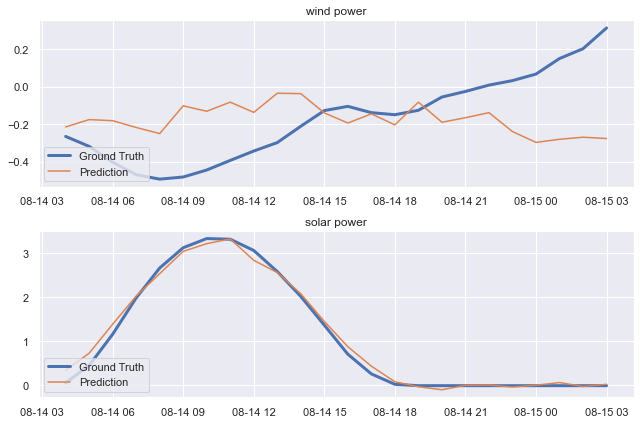

In [35]:
def plot_phis(t, X, y, y_hat, sample, sample_width):
    fig, axs = plt.subplots(2, 1, figsize=(9,6))
    axs = axs.flatten()
    titles = ["wind power", "solar power"]
    print(len(t))
    for i in range(len(axs)):
        # axs[i].plot(t[:X[0].shape[0]], X[0,:,i], lw=3, label="Input Sequence")
        axs[i].plot(t[sample][-24:], y[sample, :,i], lw=3, label="Ground Truth")
        axs[i].plot(t[sample][-24:], y_hat[sample, :,i], label="Prediction")
        axs[i].set_title(titles[i])
        axs[i].legend(loc='lower left')
    
    plt.tight_layout()


sample=10
sample_width = 7*24
plot_phis(time_test, x_test_multi, y_test_multi, y_hat, sample-1, sample_width)
# plot_phis(t, x_test_multi, y_unscaled, y_hat_unscaled, sample-1, sample_width)

# Classical Ann

In [38]:
print(x.shape[1])

17


In [ ]:
# setup classical ann for each hour
classical_ann = Sequential()
classical_ann.add(Dense(4), activation = "tanh", input_shape = x.shape[1])